In [ ]:
import os
import torch
import torchvision
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoImageProcessor, AutoModel, CLIPProcessor, CLIPModel

# Measuring photo-to-photo with CLIP + style MLP
Weights from https://github.com/PeterWang512/GenDataAttribution/tree/main

Let's check how embeddings of double exposure photography are correlated.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class LinearProbe(torch.nn.Module):
    def __init__(self, feat_dim = 512):
        super().__init__()
        self.feat_dim = feat_dim

        self.mapper = torch.nn.Linear(self.feat_dim, self.feat_dim)
        self.mapper.weight.data.copy_(torch.eye(self.feat_dim))
        self.mapper.bias.data.fill_(0)

    def load_path(self, mapper_ckpt):
        all_dicts = torch.load(mapper_ckpt)
        # real_mapper.load_state_dict(all_dicts['real_mapper'])
        self.mapper.load_state_dict(all_dicts['synth_mapper'])
        # return self

    def forward(self, input):
        x = self.mapper(input)
        x = torch.nn.functional.normalize(x, dim=-1)
        return x

In [ ]:
model = AutoModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
mlp_path = "/content/drive/MyDrive/Double-explosure-diffusion/similarity_matrix/clip_only_style.pth"
mlp = LinearProbe()
mlp.load_path(mlp_path)
mlp.to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


LinearProbe(
  (mapper): Linear(in_features=512, out_features=512, bias=True)
)

Controlnet vs Real Samples - mean: 0.35503712
Controlnet vs Real Samples - std: 0.119846076 

Similarity: Latent Blending vs Real Samples - mean: 0.2865077
Similarity: Latent Blending vs Real Samples - std: 0.13734101 

Similarity Within Double Exposure - masked mean: 0.34978613
Similarity Within Double Exposure - masked std: 0.1463366 



<ipython-input-32-6fb61c44e5ea>:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the layout to make room for the colorbar


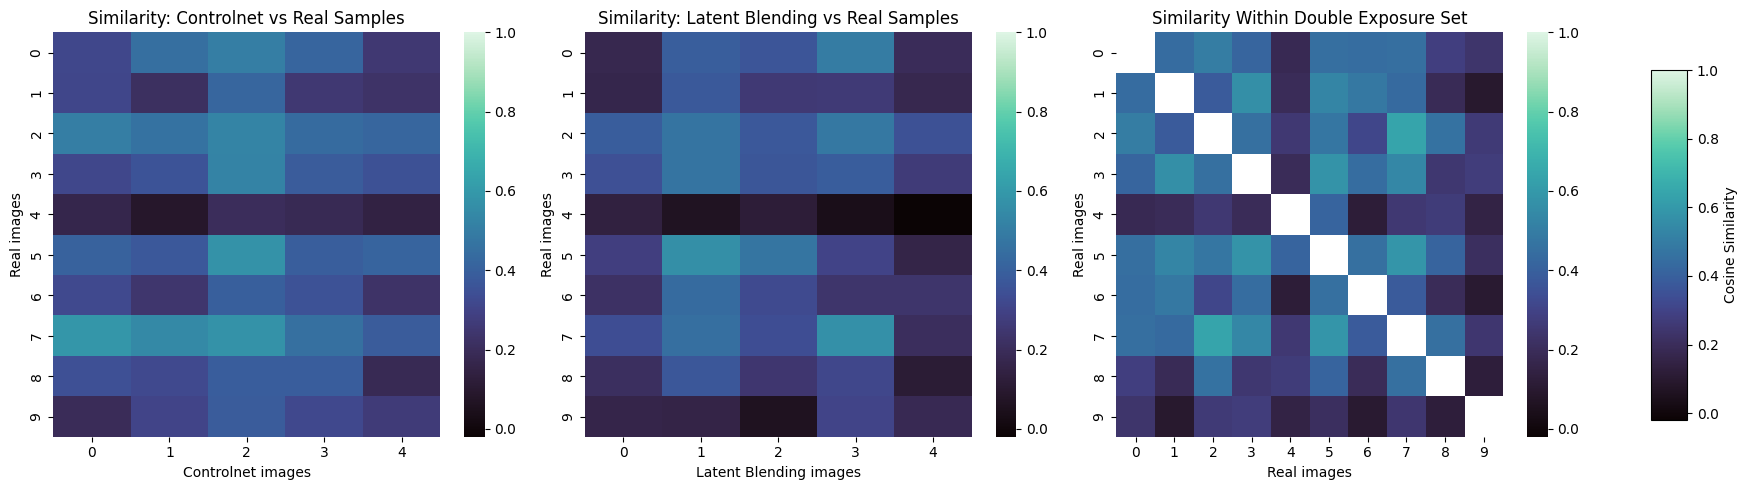

In [ ]:
resize = torchvision.transforms.Resize(512)
folder_controlnet = '/content/drive/MyDrive/Double-explosure-diffusion/Dataset/ControlNet/'
folder_sd = '/content/drive/MyDrive/Double-explosure-diffusion/Dataset/SD/'
folder_real = '/content/drive/MyDrive/Double-explosure-diffusion/Dataset/Real/'

# Load images from folder_controlnet
images_controlnet = [Image.open(folder_controlnet + i) for i in os.listdir(folder_controlnet) if i[0] != "."]
# Load images from folder_sd
images_sd = [Image.open(folder_sd + i) for i in os.listdir(folder_sd) if i[0] != "."]
# Load images from folder_real
images_real = [Image.open(folder_real + i) for i in os.listdir(folder_real) if i[0] != "."]

outputs_controlnet = []
outputs_sd = []
outputs_real = []

with torch.no_grad():
    # Process controlnet images
    for image in images_controlnet:
        inputs = processor(images=resize(image), return_tensors="pt").to("cuda")
        features_ = model.get_image_features(pixel_values=inputs.pixel_values)
        features = mlp(features_)
        outputs_controlnet.append(features.detach())

    # Process SD images
    for image in images_sd:
        inputs = processor(images=resize(image), return_tensors="pt").to("cuda")
        features_ = model.get_image_features(pixel_values=inputs.pixel_values)
        features = mlp(features_)
        outputs_sd.append(features.detach())

    # Process real photos
    for image in images_real:
        inputs = processor(images=resize(image), return_tensors="pt").to("cuda")
        features_ = model.get_image_features(pixel_values=inputs.pixel_values)
        features = mlp(features_)
        outputs_real.append(features.detach())

# Compute all similarity matrices
similarity_matrix1 = cosine_similarity(
    torch.cat(outputs_real).numpy(force=True),
    torch.cat(outputs_sd).numpy(force=True)
)

similarity_matrix2 = cosine_similarity(
    torch.cat(outputs_real).numpy(force=True),
    torch.cat(outputs_controlnet).numpy(force=True)
)

similarity_matrix3 = cosine_similarity(
    torch.cat(outputs_real).numpy(force=True),
)
# Create mask to ignore diagonal (self-similarity)
mask = ~np.ma.make_mask(np.identity(similarity_matrix3.shape[0]))

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

global_min = min(similarity_matrix1.min(), similarity_matrix2.min(), similarity_matrix3.min())
global_max = max(similarity_matrix1.max(), similarity_matrix2.max(), similarity_matrix3.max())

# Heatmap 1: Double vs Controlnet
im1 = sns.heatmap(similarity_matrix1, cmap="mako", annot=False,
              vmin=global_min, vmax=global_max, ax=axes[0])
axes[0].set_title('Similarity: Controlnet vs Real Samples')
axes[0].set_ylabel('Real images')
axes[0].set_xlabel('Controlnet images')
print("Controlnet vs Real Samples - mean:", similarity_matrix1.mean())
print("Controlnet vs Real Samples - std:", similarity_matrix1.std(), '\n')

# Heatmap 2: Double vs Latent Blending
im2 = sns.heatmap(similarity_matrix2, cmap="mako", annot=False,
              vmin=global_min, vmax=global_max, ax=axes[1])
axes[1].set_title('Similarity: Latent Blending vs Real Samples')
axes[1].set_ylabel('Real images')
axes[1].set_xlabel('Latent Blending images')
print("Similarity: Latent Blending vs Real Samples - mean:", similarity_matrix2.mean())
print("Similarity: Latent Blending vs Real Samples - std:", similarity_matrix2.std(), '\n')

# Heatmap 3: Double vs Double (within set)
im3 = sns.heatmap(similarity_matrix3, cmap="mako", annot=False,
              mask=np.identity(similarity_matrix3.shape[0]),
              vmin=global_min, vmax=global_max, ax=axes[2])
axes[2].set_title('Similarity Within Double Exposure Set')
axes[2].set_xlabel('Real images')
axes[2].set_ylabel('Real images')
print("Similarity Within Double Exposure - masked mean:", similarity_matrix3[mask].mean())
print("Similarity Within Double Exposure - masked std:", similarity_matrix3[mask].std(), '\n')

# Add a colorbar with the same scale for all plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1.get_children()[0], cax=cbar_ax, label='Cosine Similarity')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the layout to make room for the colorbar
plt.show()

In [67]:
for index in similarity_matrix1.mean(axis=0).argsort()[::-1]:
    image = images_controlnet[index]
    w, h = image.size
    # display(image.resize((int(w/h*100), 100)))
    print('File:', os.listdir(folder_controlnet)[index])
    print('Score:', similarity_matrix1.mean(axis=0)[index], '\n')

for index in similarity_matrix2.mean(axis=0).argsort()[::-1]:
    image = images_sd[index]
    w, h = image.size
    # display(image.resize((int(w/h*100), 100)))
    print('File:', os.listdir(folder_sd)[index])
    print('Score:', similarity_matrix2.mean(axis=0)[index], '\n')


for index in np.reshape(similarity_matrix3[mask], (10,9)).mean(axis=1).argsort()[::-1]:
    image = images_real[index]
    w, h = image.size
    # display(image.resize((int(w/h*100), 100)))
    print('File: ', os.listdir(folder_real)[index])
    print('Score:', np.reshape(similarity_matrix3[mask], (10,9)).mean(axis=1)[index], '\n')


File: controlnet12.jpg
Score: 0.4490734 

File: controlnet11.jpg
Score: 0.35837895 

File: controlnet4.jpg
Score: 0.34566468 

File: controlnet16.jpg
Score: 0.33501023 

File: controlnet9.jpg
Score: 0.28705853 

File: 08-015_man_forest_1.png
Score: 0.3744598 

File: 08-015_mountains_woman_0.png
Score: 0.33936602 

File: 08-015_man_forest_2.png
Score: 0.29086298 

File: 08-015_man_forest_0.png
Score: 0.24193951 

File: 08-015_mountains_woman_2.png
Score: 0.18591012 

File:  Copy of pexels-kseniya-kopna-52379050-7723547.jpg
Score: 0.45558065 

File:  relander-2.jpg
Score: 0.44085115 

File:  Copy of pexels-nguy-n-thanh-ng-c-485749-3995673.jpg
Score: 0.413988 

File:  Copy of pexels-mati-6345007.jpg
Score: 0.41175097 

File:  Copy of pexels-nguy-n-trung-phuc-1772580055-28227424.jpg
Score: 0.37757862 

File:  Copy of pexels-stayhereforu-216201233-14455740.jpg
Score: 0.3673993 

File:  Copy of pexels-27-1-418919857-18465473.jpg
Score: 0.32489276 

File:  relander-8.jpg
Score: 0.29226533 

F

# Measuring text-to-photo with CLIP

In [ ]:
token = '' # add yours

In [ ]:
model = CLIPModel.from_pretrained('openai/clip-vit-large-patch14-336', token=token).to('cuda')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-large-patch14-336', token=token)

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Controlnet vs Real Samples - mean: 0.35503712
Controlnet vs Real Samples - std: 0.119846076 

Similarity: Latent Blending vs Real Samples - mean: 0.2865077
Similarity: Latent Blending vs Real Samples - std: 0.13734101 

Similarity Within Double Exposure - masked mean: 0.34978613
Similarity Within Double Exposure - masked std: 0.1463366 



<ipython-input-17-226d213ab482>:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the layout to make room for the colorbar


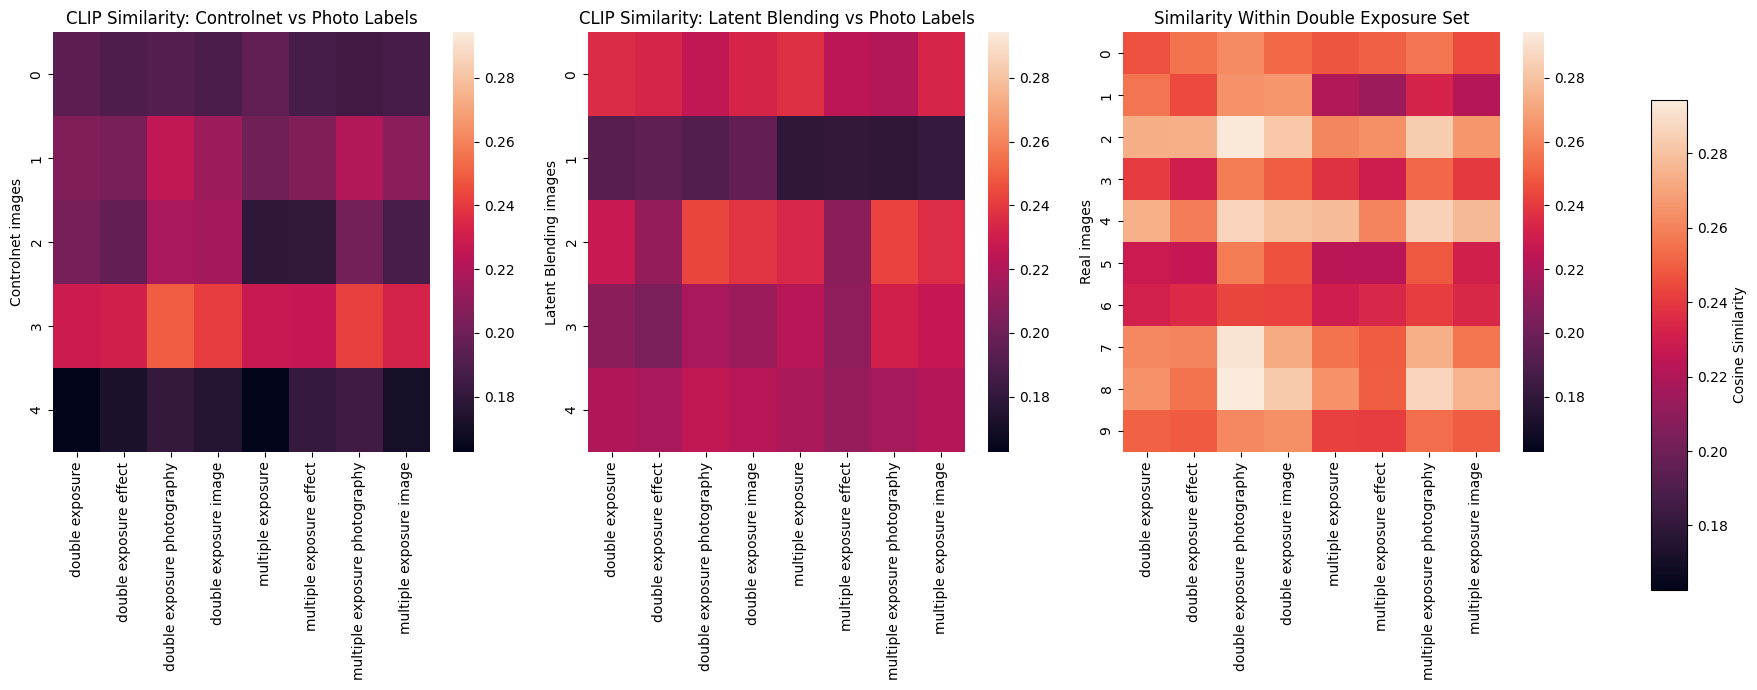


Controlnet similarity - mean: 0.20132661
Controlnet similarity - std: 0.022326238

Blended latents similarity - mean: 0.21662214
Blended latents similarity - std: 0.017776428
Original Photos similarity - mean: 0.25434303
Original Photos similarity - std: 0.018994326


In [ ]:
resize = torchvision.transforms.Resize(512)
folder_controlnet = '/content/drive/MyDrive/Double-explosure-diffusion/Dataset/ControlNet/'
folder_sd = '/content/drive/MyDrive/Double-explosure-diffusion/Dataset/SD/'
folder_real = '/content/drive/MyDrive/Double-explosure-diffusion/Dataset/Real/'

# Load images from folder_controlnet
images_controlnet = [Image.open(folder_controlnet + i) for i in os.listdir(folder_controlnet) if i[0] != "."]
# Load images from folder_sd
images_sd = [Image.open(folder_sd + i) for i in os.listdir(folder_sd) if i[0] != "."]
# Load images from folder_real
images_real = [Image.open(folder_real + i) for i in os.listdir(folder_real) if i[0] != "."]

outputs_controlnet = []
outputs_sd = []
outputs_real = []

# Define text labels for similarity comparison
labels = [
    'double exposure',
    'double exposure effect',
    'double exposure photography',
    'double exposure image',

    'multiple exposure',
    'multiple exposure effect',
    'multiple exposure photography',
    'multiple exposure image',
]

with torch.no_grad():
    # Process text labels
    text_features_list = []
    for tag in labels:
        text_inputs = processor(text=tag, return_tensors="pt", padding=True).to('cuda')
        text_features = model.get_text_features(**text_inputs)
        text_features_list.append(text_features)

    # Stack text features
    text_features = torch.cat(text_features_list, dim=0)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)

    # Process original photos
    photo_inputs = processor(images=images_real, return_tensors="pt", padding=True).to('cuda')
    photo_features = model.get_image_features(**photo_inputs)
    photo_features = photo_features / photo_features.norm(dim=1, keepdim=True)

    # Process controlnets
    controlnet_inputs = processor(images=images_controlnet, return_tensors="pt", padding=True).to('cuda')
    controlnet_features = model.get_image_features(**controlnet_inputs)
    controlnet_features = controlnet_features / controlnet_features.norm(dim=1, keepdim=True)

    # Process sd
    sd_inputs = processor(images=images_sd, return_tensors="pt", padding=True).to('cuda')
    sd_features = model.get_image_features(**sd_inputs)
    sd_features = sd_features / sd_features.norm(dim=1, keepdim=True)

    # Calculate similarity matrices
    photo_text_similarity = (photo_features @ text_features.T).cpu().numpy()
    controlnet_similarity = (controlnet_features @ text_features.T).cpu().numpy()
    sd_similarity = (sd_features @ text_features.T).cpu().numpy()

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

global_min = min(photo_text_similarity.min(), controlnet_similarity.min(), sd_similarity.min())
global_max = max(photo_text_similarity.max(), controlnet_similarity.max(), sd_similarity.max())

# Heatmap 1: Double vs Controlnet
im1 = sns.heatmap(controlnet_similarity, cmap="rocket", annot=False,
              vmin=global_min, vmax=global_max, ax=axes[0], xticklabels=labels)
axes[0].set_title('CLIP Similarity: Controlnet vs Photo Labels')
axes[0].set_ylabel('Controlnet images')
print("Controlnet vs Real Samples - mean:", similarity_matrix1.mean())
print("Controlnet vs Real Samples - std:", similarity_matrix1.std(), '\n')

# Heatmap 2: Double vs Latent Blending
im2 = sns.heatmap(sd_similarity, cmap="rocket", annot=False,
              vmin=global_min, vmax=global_max, ax=axes[1], xticklabels=labels)
axes[1].set_title('CLIP Similarity: Latent Blending vs Photo Labels')
axes[1].set_ylabel('Latent Blending images')
print("Similarity: Latent Blending vs Real Samples - mean:", similarity_matrix2.mean())
print("Similarity: Latent Blending vs Real Samples - std:", similarity_matrix2.std(), '\n')

# Heatmap 3: Double vs Double (within set)
im3 = sns.heatmap(photo_text_similarity, cmap="rocket", annot=False,
              vmin=global_min, vmax=global_max, ax=axes[2], xticklabels=labels)
axes[2].set_title('Similarity Within Double Exposure Set')
axes[2].set_ylabel('Real images')
print("Similarity Within Double Exposure - masked mean:", similarity_matrix3[mask].mean())
print("Similarity Within Double Exposure - masked std:", similarity_matrix3[mask].std(), '\n')

# Add a colorbar with the same scale for all plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1.get_children()[0], cax=cbar_ax, label='Cosine Similarity')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the layout to make room for the colorbar
plt.show()


# Print statistics for each similarity matrix
print("\nControlnet similarity - mean:", controlnet_similarity.mean())
print("Controlnet similarity - std:", controlnet_similarity.std())
print("\nBlended latents similarity - mean:", sd_similarity.mean())
print("Blended latents similarity - std:", sd_similarity.std())
print("Original Photos similarity - mean:", photo_text_similarity.mean())
print("Original Photos similarity - std:", photo_text_similarity.std())